In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image,ImageOps 
import os
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# SK learn imports
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
# Tensorflow imports
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Keras imports
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.utils import to_categorical

'''

Below is just to check if there any available GPU

'''
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List available devices
print("Available devices:", tf.config.list_physical_devices())

Num GPUs Available:  1
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Check the image mode to understand it better for training purposes

In [13]:
# Check the mode of image
sample_image_directory = '../Datasets/mrlEyes/s0001/s0001_00001_0_0_0_0_0_01.png'
image = image = Image.open(sample_image_directory)
print("Image mode: ",image.mode)

# All the images are in grayscale mode (i.e L 8-bit grayscale)

Image mode:  L


# Preprocessing images

In [14]:
# Initialize lists to store image data and labels
img_path_list = []
label = []

# Define the path to the directory containing the images
directory = '../Datasets/mrlEyes'

# Loop through each subdirectory and process images
for i in tqdm(os.listdir(directory), desc="Processing directories"):
    # Construct the full path to each subdirectory in 'directory'
    sub_path = os.path.join(directory, i)
    if os.path.isdir(sub_path):
        # Use tqdm for tracking progress within each subdirectory
        for j in tqdm(os.listdir(sub_path), desc=f"Processing images in {i}", leave=False):
            img_path = os.path.join(sub_path, j)
            img_path_list.append(img_path)

            # Assign labels based on filename convention
            if len(j) > 16 and j[16] == '1':  # Ensure index 16 exists in filename
                label.append(1)  # Drowsy
            else:
                label.append(0)  # Non-Drowsy

label = np.array(label)

print("Label shape:", label.shape)


Processing directories: 100%|██████████| 40/40 [00:00<00:00, 107.68it/s]


Label shape: (84898,)


Split the dataset based on the user preferences

In [15]:
# Split into train, validation, and test sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(img_path_list, label, test_size=0.3, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, random_state=42)

# Visualize original images with their respective labels

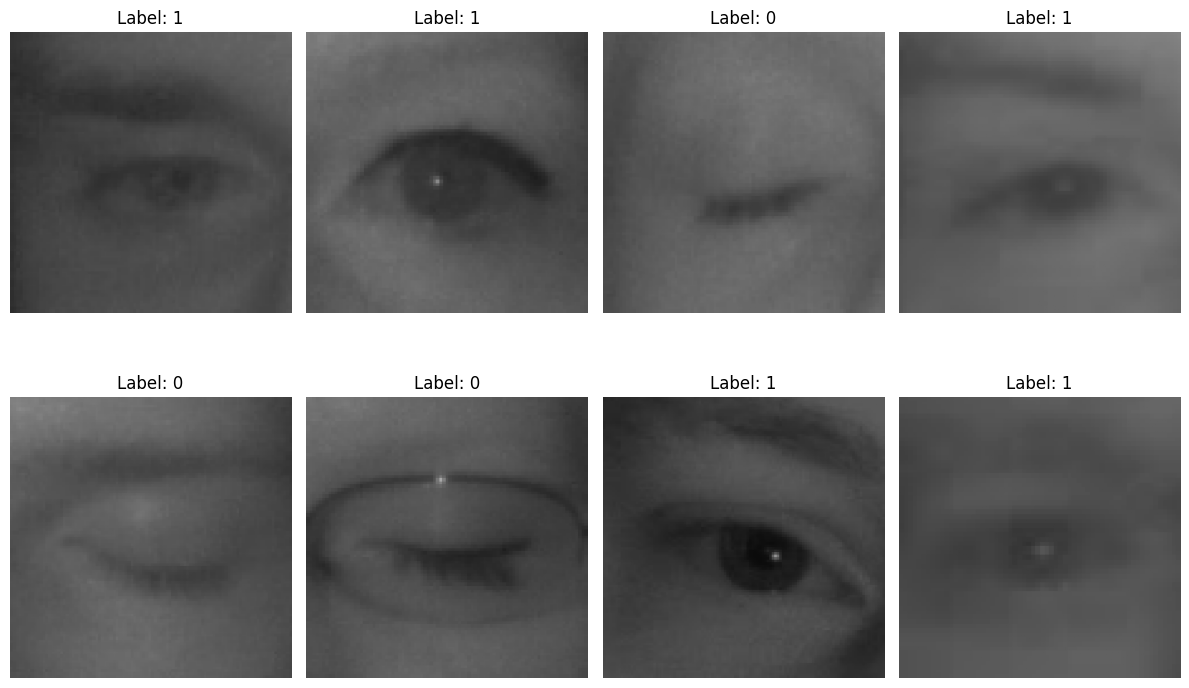

In [16]:
# Visualize original images (before augmentation)
batch_paths, batch_labels = train_paths[:8], train_labels[:8]  # Use first 8 images for visualization

plt.figure(figsize=(12, 8))
for i, img_path in enumerate(batch_paths):
    # Load and preprocess the image
    original_image = load_img(img_path, target_size=(224, 224), color_mode='rgb')  # Load image
    original_image = img_to_array(original_image) / 255.0  # Normalize pixel values

    # Plot the original image
    plt.subplot(2, 4, i + 1)  # Arrange images in a 2x4 grid
    plt.imshow(original_image)
    plt.title(f"Label: {batch_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Perform Augmentation to the images to better train the data

In [17]:
# Define an augmentation generator
augmentation_generator = ImageDataGenerator(
        rotation_range=90,          # Slight rotations
        horizontal_flip=True,       # Flip horizontally
        zoom_range=0.5,             # Slight zoom in/out
        width_shift_range=0.1,      # Horizontal shifts
        height_shift_range=0.1,     # Vertical shifts
        shear_range=10,             # Shearing distortions
        fill_mode='nearest'         # Fill missing pixels
)

In [18]:
# Define a custom DataGenerator class
class MRLDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=32, target_size=(224, 224),shuffle = True, augment = False):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        # Calculate the number of batches per epoch
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        # Fetch batch data
        batch_paths = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = []
        for file_path in batch_paths:
            # Load and preprocess the image
            image = load_img(file_path, target_size=self.target_size, color_mode='rgb')
            image = img_to_array(image) / 255.0  # Normalize to [0, 1]
            if self.augment:
                image = augmentation_generator.random_transform(image)
            images.append(image)
        
        return np.array(images), np.array(batch_labels)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Batch size
batch_size = 32

# Create generators
train_generator = MRLDataGenerator(train_paths, train_labels, batch_size=batch_size, augment = True)
val_generator = MRLDataGenerator(val_paths, val_labels, batch_size=batch_size)
test_generator = MRLDataGenerator(test_paths, test_labels, batch_size=batch_size)


# Visualize the original images VS augmented images

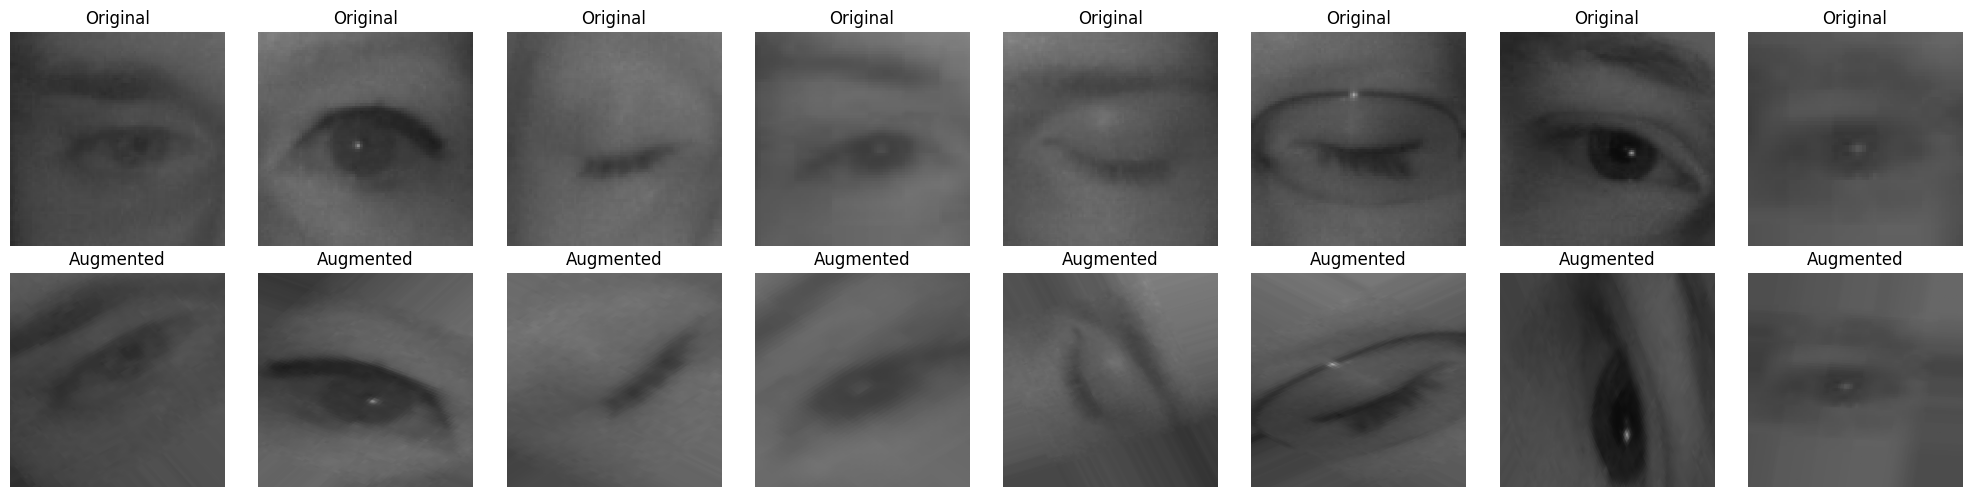

In [19]:
original_images = []
for i in range(8):  # Load first 8 images
    img_path = train_paths[i]
    original_image = load_img(img_path, target_size=(224, 224), color_mode='rgb')
    original_images.append(img_to_array(original_image) / 255.0)  # Normalize

# Get augmented images from the generator
batch_images, batch_labels = train_generator[0]  # First batch with augment=True

# Plot comparison of original and augmented images horizontally
plt.figure(figsize=(20, 5))  # Adjust figure size for horizontal layout

for i in range(8):
    # Plot original image
    plt.subplot(2, 8, i + 1)  # 2 rows, 8 columns (row 1: original)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.axis('off')

    # Plot augmented image
    plt.subplot(2, 8, i + 9)  # 2 rows, 8 columns (row 2: augmented)
    plt.imshow(batch_images[i])
    plt.title("Augmented")
    plt.axis('off')

plt.tight_layout(pad=1.0)  # Reduce gaps between plots
plt.show()


# Using Mobile Net V2

In [20]:
# Load MobileNetV2 for transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model
# base_model.summary()

In [ ]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model

In [ ]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',            # Monitor validation loss
    patience=3,                    # Stop training after 3 epochs without improvement
    restore_best_weights=True,     # Restore the best model weights
    verbose=1                      # Print early stopping messages
)
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping] 
)


Epoch 1/10
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 766s 410ms/step - accuracy: 0.8724 - loss: 0.2972 - val_accuracy: 0.9152 - val_loss: 0.2021
Epoch 2/10


2024-11-19 16:04:44.001791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-19 16:04:44.001811: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15702233831767097986
2024-11-19 16:04:44.001817: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2970640610614106966
2024-11-19 16:04:44.001863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_16]]
2024-11-19 16:04:44.001876: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14931787845066897621
2024-11-19 16:04:44.001881: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8439656732855752244
2024-11-

1858/1858 ━━━━━━━━━━━━━━━━━━━━ 0s 142us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


/Users/sufi/Desktop/Term 7/Driver-Fatigue-System/.venv/lib/python3.9/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


1858/1858 ━━━━━━━━━━━━━━━━━━━━ 766s 412ms/step - accuracy: 0.9102 - loss: 0.2249 - val_accuracy: 0.8835 - val_loss: 0.2553
Epoch 4/10
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10


2024-11-19 16:17:30.433761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-19 16:17:30.433796: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15702233831767097986
2024-11-19 16:17:30.433825: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2970640610614106966
2024-11-19 16:17:30.433838: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8439656732855752244
2024-11-19 16:17:30.433846: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9961241838843342738
2024-11-19 16:17:30.433853: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14931787845066897621
2024-11-19 16:17:30.433860: I tensorflow/core/framework/local_rendezv

1858/1858 ━━━━━━━━━━━━━━━━━━━━ 776s 418ms/step - accuracy: 0.9128 - loss: 0.2140 - val_accuracy: 0.8960 - val_loss: 0.2445
Epoch 6/10
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 0s 33us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10


2024-11-19 16:30:26.618742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-19 16:30:26.618763: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15702233831767097986
2024-11-19 16:30:26.618769: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2970640610614106966
2024-11-19 16:30:26.618774: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8439656732855752244
2024-11-19 16:30:26.618780: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9961241838843342738
2024-11-19 16:30:26.618786: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14931787845066897621
2024-11-19 16:30:26.618792: I tensorflow/core/framework/local_rendezv

1858/1858 ━━━━━━━━━━━━━━━━━━━━ 1035s 557ms/step - accuracy: 0.9151 - loss: 0.2092 - val_accuracy: 0.8878 - val_loss: 0.2442
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 1.
398/398 ━━━━━━━━━━━━━━━━━━━━ 101s 255ms/step - accuracy: 0.9124 - loss: 0.2100
Test Accuracy: 0.91


# Evaluate the model with test data

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy:.2f}")

# Save the model to use in detection.py

In [22]:
model.save('../content/model-after-augmv2.h5', overwrite=True)